In [13]:
import pandas as pd
import numpy as np
import csv
import seaborn as sns
import copy
from scipy import stats
from sklearn.metrics import f1_score
import pyspark
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
#import the csv data file
data = pd.read_csv("LiveStream-1-Cam-2-New-NL.csv")

In [56]:
data

,Date,Time,Timer,Temperature,Condition,Light,Car,CarDuration
0,2022-06-26,06-58-11.741,45.0,14.97,mist,Red,False,2
1,2022-06-26,06-58-18.254,8.0,14.97,mist,Green,False,0
2,2022-06-26,06-59-26.896,66.0,15.05,mist,Red,False,0
3,2022-06-26,06-59-35.205,7.0,15.05,mist,Green,False,1
4,2022-06-26,07-00-39.761,63.0,15.05,mist,Red,False,0
...,...,...,...,...,...,...,...,...
2173,2022-06-29,01-30-14.859,7.0,16.95,few clouds,Green,False,2
2174,2022-06-29,01-36-36.451,382.0,16.83,scattered clouds,Red,True,3
2175,2022-06-29,01-36-42.591,4.0,16.83,scattered clouds,Green,False,1
2176,2022-06-29,01-36-42.821,1.0,16.83,scattered clouds,Red,False,0


In [16]:
#copy the dataframe to a new dataframe in order to do some processing
newDf = data[['Timer','Car','CarDuration','Light']].copy()

[Text(0, 0.5, 'Count')]

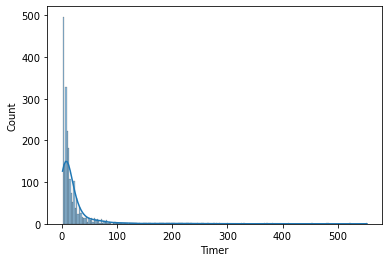

In [17]:
#timer distribution in the dataset
ax = sns.histplot(newDf['Timer'], kde=True)
ax.set( ylabel='Count')

In [18]:
#outlier detection and elimination using IQR

percentile25 = newDf['Timer'].quantile(0.25)
percentile75 = newDf['Timer'].quantile(0.75)
iqr = percentile75 - percentile25

#select upper limit and showcase potential outliers
upperLimit = percentile75 + 1.5*iqr
lowerLimit = 1
newDfOut = newDf[newDf['Timer'] < upperLimit]
newDfOut.drop(newDfOut[newDfOut['Timer'] == 1].index, inplace = True)

C:\Users\ronan\anaconda3\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [19]:
newDfOut['CarDuration'].value_counts()

0     744
1     263
2     196
3     109
4      89
5      50
7      28
6      23
8      19
12     12
10     11
9      11
18      8
11      5
15      4
16      4
14      3
13      3
19      3
17      2
26      2
28      1
20      1
21      1
25      1
29      1
Name: CarDuration, dtype: int64

[Text(0, 0.5, 'Count')]

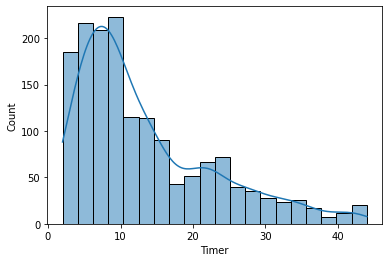

In [43]:
#new timer distribution in the dataset
ax = sns.histplot(newDfOut['Timer'], kde=True)
ax.set( ylabel='Count')

In [44]:
#encoding the values
le = LabelEncoder()
newDfOut['Light'] = le.fit_transform(newDfOut['Light'])
newDfOut['Car'] = le.fit_transform(newDfOut['Car'])

<ipython-input-44-04dc45a6528a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newDfOut['Light'] = le.fit_transform(newDfOut['Light'])
<ipython-input-44-04dc45a6528a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newDfOut['Car'] = le.fit_transform(newDfOut['Car'])


In [45]:
#splitting the dataset into features and target
feature_cols = list(newDfOut.columns[:-1])
target_col = newDfOut.columns[-1]

X_all = newDfOut[feature_cols]
Y_all = newDfOut[target_col]

#split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_all, Y_all, test_size=0.33, random_state=43)

In [46]:
#gridsearching
param_grid = [{'C': 10**np.linspace(-3,3,20)}]
lin_reg = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
logreg = GridSearchCV(lin_reg, param_grid, cv=10, scoring='accuracy', 
                             refit=True)
#training a logistic regression model
logreg.fit(X_train,y_train)

#predicting
y_pred=logreg.best_estimator_.predict(X_test)

In [47]:
#evaluating the performance of the model
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
print('Recall: ',metrics.recall_score(y_test, y_pred, zero_division=1))
print('Precision:',metrics.precision_score(y_test, y_pred, zero_division=1))
print('F1:',metrics.f1_score(y_test, y_pred, zero_division=1))
print('CL Report:',metrics.classification_report(y_test, y_pred, zero_division=1))

Accuracy:  0.793168880455408
Recall:  0.6371681415929203
Precision: 0.8421052631578947
F1: 0.72544080604534
CL Report:               precision    recall  f1-score   support

           0       0.77      0.91      0.83       301
           1       0.84      0.64      0.73       226

    accuracy                           0.79       527
   macro avg       0.81      0.77      0.78       527
weighted avg       0.80      0.79      0.79       527



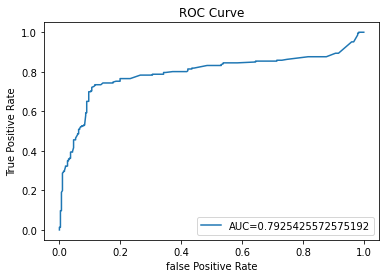

In [48]:
#ROC curve calculation

y_pred_proba= logreg.best_estimator_.predict_proba(X_test) [::,1]

false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test, y_pred_proba)

auc= metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(false_positive_rate, true_positive_rate,label="AUC="+str(auc))
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)

In [49]:
#training a decision tree classifier
my_random_seed = 45

tree_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

model = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=5)

model.fit(X_train, y_train)

model.best_score_

0.856592514589092

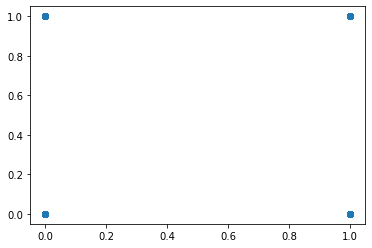

In [50]:
#decision tree prediction
y_predict = model.best_estimator_.predict(X_test)

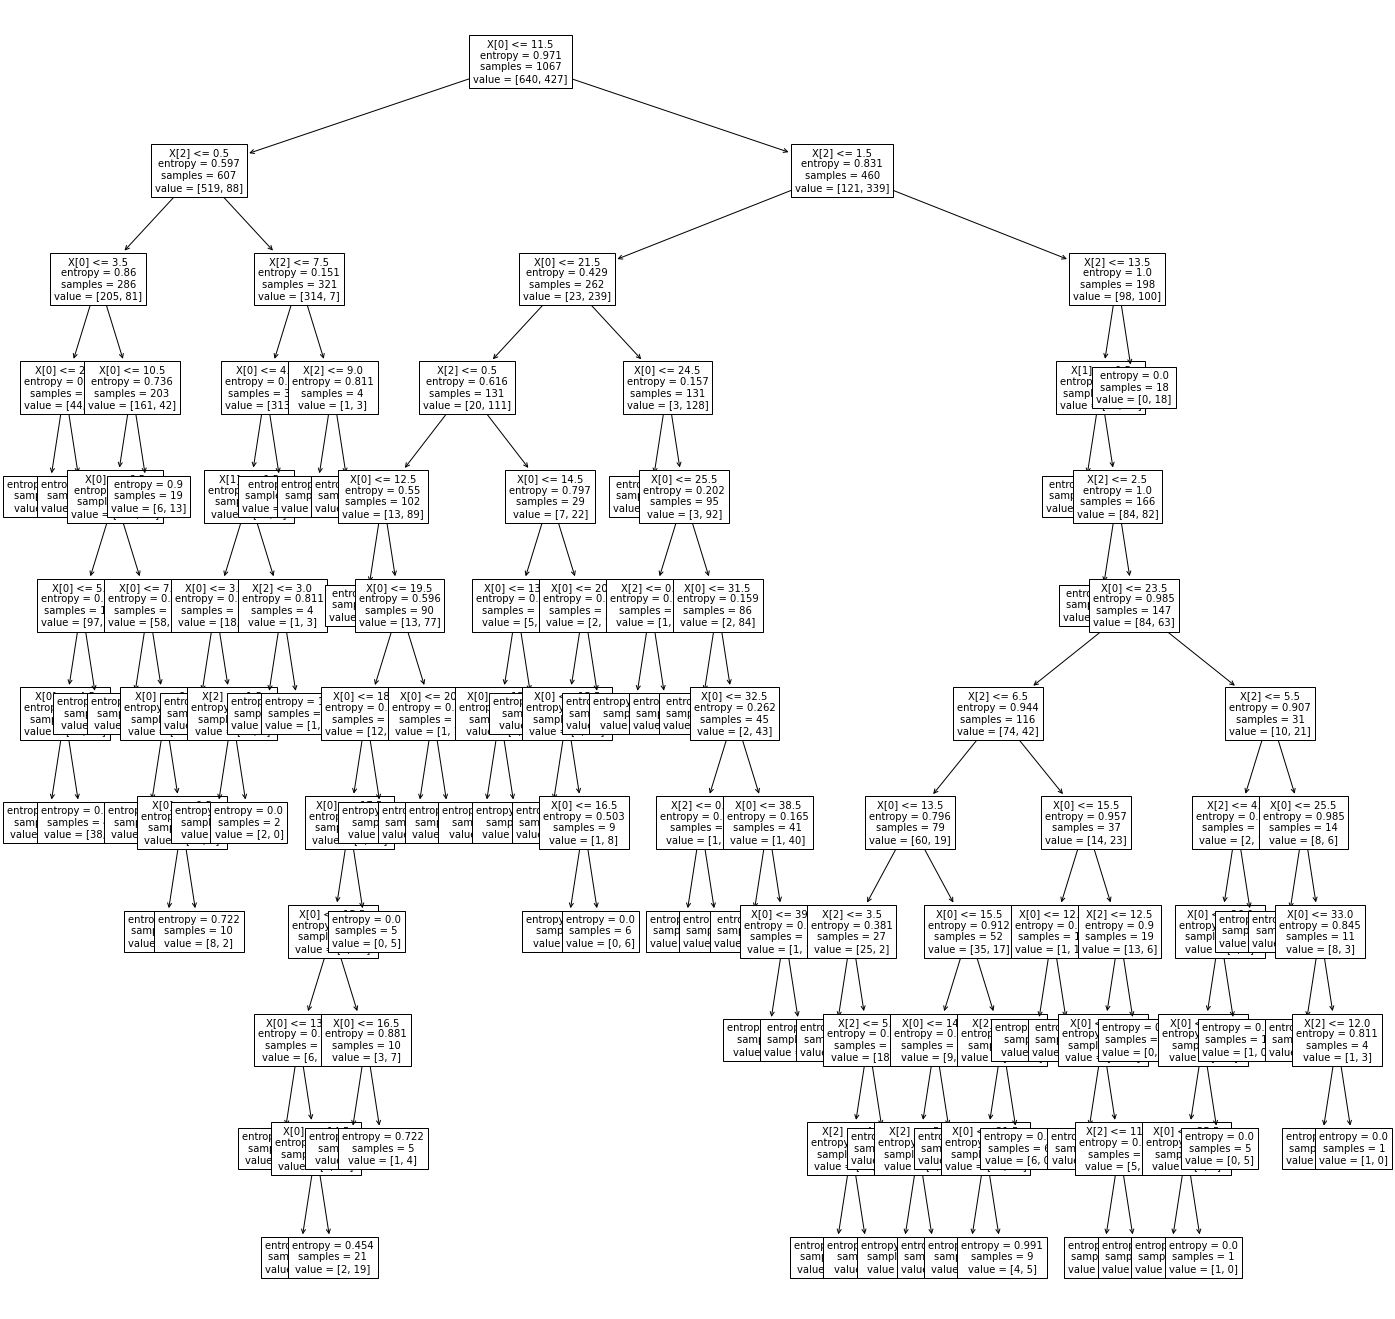

In [51]:
#visualizing the tree
plt.figure(figsize=(24,24))  # set plot size (denoted in inches)
tree.plot_tree(model.best_estimator_, fontsize=10)
plt.show()

In [52]:
#evaluating the performance of the model
print('Accuracy: ',metrics.accuracy_score(y_test, y_predict))
print('Recall: ',metrics.recall_score(y_test, y_predict, zero_division=1))
print('Precision:',metrics.precision_score(y_test, y_predict, zero_division=1))
print('F1:',metrics.f1_score(y_test, y_predict, zero_division=1))
print('CL Report:',metrics.classification_report(y_test, y_predict, zero_division=1))

Accuracy:  0.8273244781783681
Recall:  0.7345132743362832
Precision: 0.8426395939086294
F1: 0.784869976359338
CL Report:               precision    recall  f1-score   support

           0       0.82      0.90      0.86       301
           1       0.84      0.73      0.78       226

    accuracy                           0.83       527
   macro avg       0.83      0.82      0.82       527
weighted avg       0.83      0.83      0.83       527



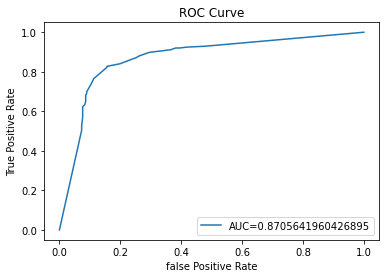

In [53]:
#ROC curve calculation

y_pred_proba= model.best_estimator_.predict_proba(X_test) [::,1]

false_positive_rate, true_positive_rate, _ = metrics.roc_curve(y_test, y_pred_proba)

auc= metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(false_positive_rate, true_positive_rate,label="AUC="+str(auc))
plt.title('ROC Curve')
plt.ylabel('True Positive Rate')
plt.xlabel('false Positive Rate')
plt.legend(loc=4)